# Image classification: French cheeses

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2021-11-10 18:54:18.863785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-10 18:54:18.863808: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import dataset

In this notebook we use the dataset ```auto_dataset_cleaned```, which uses a script to automatically download images from the internet, that are then checked manually.


In [33]:
# Retrieve dataset
dataset_url = "https://github.com/seub/Cheezam/raw/main/data/cheese_photos.tar.gz"
data_dir = tf.keras.utils.get_file('cheese_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(f'The data_dir is: {data_dir}')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg')))
print(f'Found {image_count} jpg and jpeg images.')

The data_dir is: /home/brice/.keras/datasets/cheese_photos
Found 3619 jpg and jpeg images.


## Create a tf.keras dataset

In [51]:
batch_size = 32
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")

Found 3622 files belonging to 15 classes.
Using 3478 files for training.
Found 3622 files belonging to 15 classes.
Using 144 files for validation.
Class names: ["Bleu d'Auvergne", 'Brie de Meaux', 'Brie de Melun', 'Camembert de Normandie', 'Cantal', 'Comte', 'Emmenthal de Savoie', "Fourme d'Ambert", 'Fourme de Montbrison', 'Mimolette', 'Morbier', 'Ossau-Iraty', 'Rocamadour', 'Roquefort', 'Saint-Nectaire']


## Visualize the data

Here are the first nine images from the training dataset:

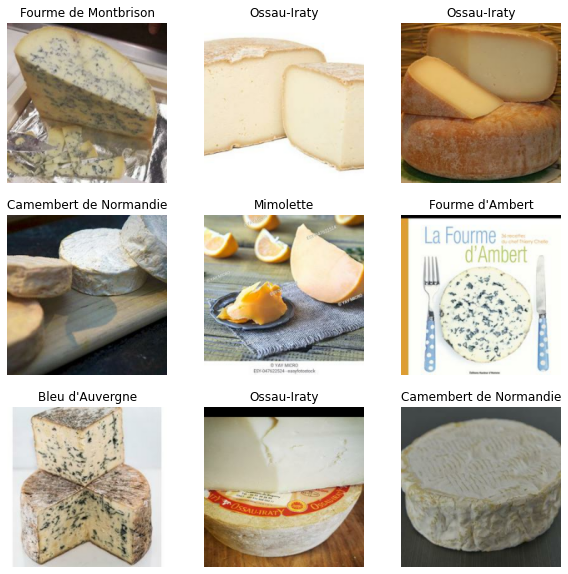

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [37]:
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(0.1, fill_mode='constant', input_shape=input_shape),
    layers.RandomZoom(0.1, fill_mode='constant'),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant')
    #layers.RandomFlip("horizontal")
  ])

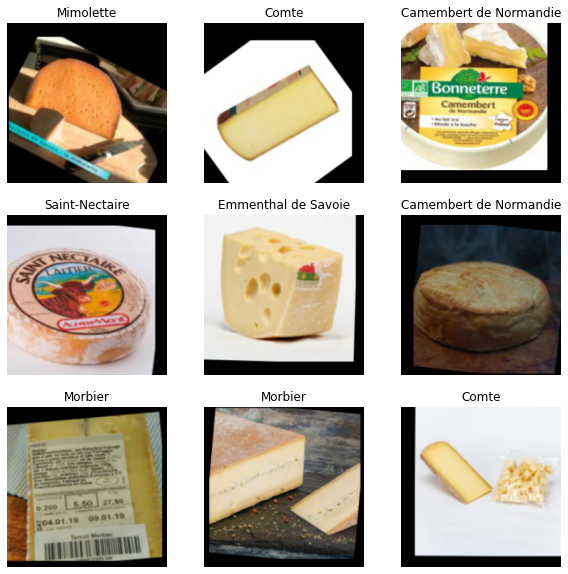

In [38]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    img_aug = data_augmentation(img)
    plt.imshow(img_aug.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [60]:
import pickle

model_path = pathlib.Path.home() / '.keras/models/auto_cleaned/model0'
print(model_path)

def load_model(reset):
  if reset:
    tf.keras.backend.clear_session()
    model = Sequential([
      data_augmentation,
      layers.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.summary()
    return model
  else:
    model = keras.models.load_model(model_path)
    model.summary()
    return model

def update_history(reset, history, model_path):
  model_path.mkdir(parents=False, exist_ok=True)
  history_path = model_path / 'training_history'
  if reset or (not history_path.is_file()):
    training_history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[], 'epochs':0}
  else:
    training_history = pickle.load(open(history_path, 'rb'))
  training_history['acc'] += history.history['accuracy']
  training_history['val_acc'] += history.history['val_accuracy']
  training_history['loss'] += history.history['loss']
  training_history['val_loss'] += history.history['val_loss']
  training_history['epochs'] += epochs
  with open(history_path, 'wb') as file_pi:
    pickle.dump(training_history, file_pi)
  return training_history

/home/brice/.keras/models/auto_cleaned/model0


In [40]:
reset = True
if reset==False:
  assert model_path.is_dir()
epochs = 1

model = load_model(reset=reset)

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

model.save(model_path)
training_history = update_history(reset=reset, history=history, model_path=model_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        1

## Visualize training results

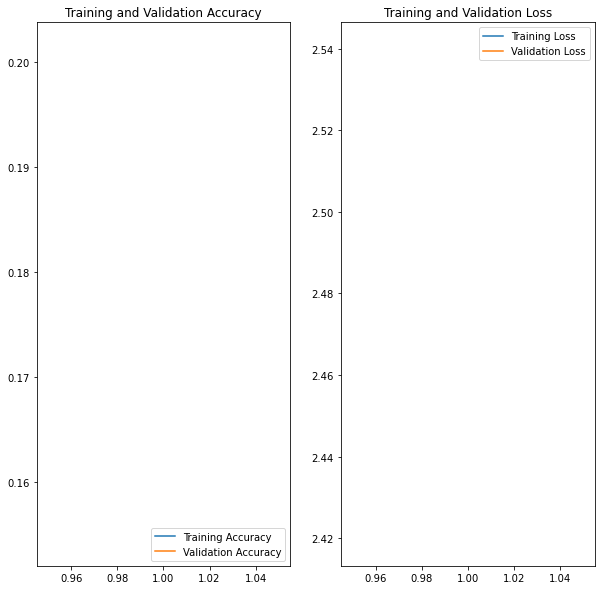

In [77]:
def visualize_training(training_history):
    epochs_range = range(1, 1+training_history['epochs'])

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_history['acc'], label='Training Accuracy')
    plt.plot(epochs_range, training_history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_history['loss'], label='Training Loss')
    plt.plot(epochs_range, training_history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig("training_history.png")
    plt.show()
visualize_training(training_history)

## Predict on new data

In [42]:
from IPython.display import display

def cheezam(filepath : str):
    img = tf.keras.utils.load_img(filepath, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    display( PIL.Image.open(filepath).resize((img_height, img_width)) )

    print(
    "This cheese is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

    

10


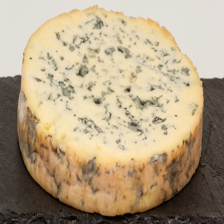

This cheese is most likely a Camembert de Normandie with a 9.81 percent confidence.


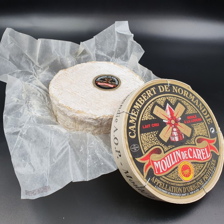

This cheese is most likely a Roquefort with a 14.98 percent confidence.


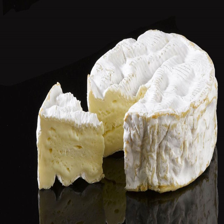

This cheese is most likely a Saint-Nectaire with a 11.24 percent confidence.


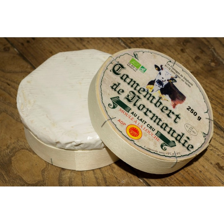

This cheese is most likely a Camembert de Normandie with a 10.31 percent confidence.


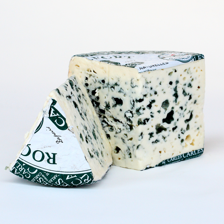

This cheese is most likely a Roquefort with a 23.79 percent confidence.


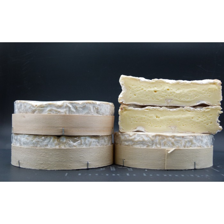

This cheese is most likely a Roquefort with a 13.61 percent confidence.


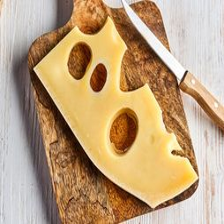

This cheese is most likely a Mimolette with a 30.35 percent confidence.


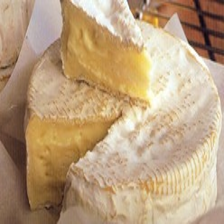

This cheese is most likely a Emmenthal de Savoie with a 14.57 percent confidence.


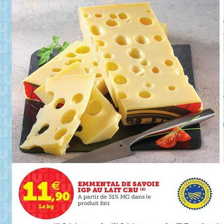

This cheese is most likely a Emmenthal de Savoie with a 18.22 percent confidence.


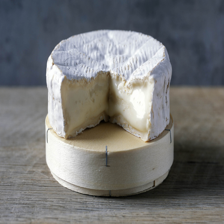

This cheese is most likely a Roquefort with a 15.04 percent confidence.


In [43]:
import random
test_dir = pathlib.Path('data/sample_dataset')
test_paths_total = list(test_dir.glob('*/*.jpg'))
nb_test, nb_test_total = 10, len(test_paths_total)
test_paths = random.sample(test_paths_total, nb_test)
print(len(test_paths))
for test_path in test_paths:
    cheezam(test_path)

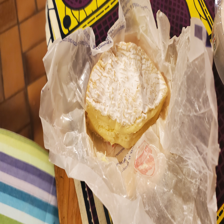

This cheese is most likely a Emmenthal de Savoie with a 16.86 percent confidence.


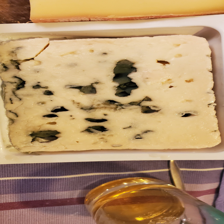

This cheese is most likely a Emmenthal de Savoie with a 14.78 percent confidence.


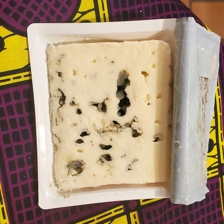

This cheese is most likely a Saint-Nectaire with a 11.63 percent confidence.


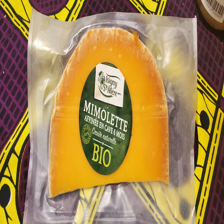

This cheese is most likely a Mimolette with a 65.09 percent confidence.


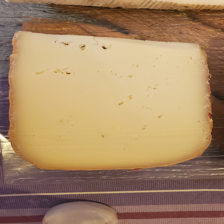

This cheese is most likely a Emmenthal de Savoie with a 15.90 percent confidence.


In [44]:
photos_brice_dir = pathlib.Path('data/photos_brice')
photos_brice_paths = list(photos_brice_dir.glob('*.jpg'))
for photo in photos_brice_paths:
    cheezam(photo)

In [47]:
import inspect
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
print(model_dictionary.keys())

dict_keys(['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception'])


In [52]:
model_func = model_dictionary['MobileNetV2']
base_model = model_func(include_top=False, pooling='avg', input_shape=input_shape, weights = 'imagenet')
base_model.trainable = False

model1 = tf.keras.models.Sequential()
model1.add(base_model)
model1.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'])

109/109 [==============================] - 80s 728ms/step - loss: 2.3712 - accuracy: 0.1817 - val_loss: 2.4022 - val_accuracy: 0.2292


In [73]:
epochs = 30
model_path1 = pathlib.Path.home() / '.keras/models/auto_cleaned/model1'
history1 = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
training_history1 = update_history(reset=False, history=history1, model_path=model_path1)

Epoch 1/30
109/109 [==============================] - 147s 1s/step - loss: 1.1448 - accuracy: 0.5900 - val_loss: 1.4825 - val_accuracy: 0.5069
Epoch 2/30
109/109 [==============================] - 148s 1s/step - loss: 1.1205 - accuracy: 0.5983 - val_loss: 1.5935 - val_accuracy: 0.4792
Epoch 3/30
109/109 [==============================] - 148s 1s/step - loss: 1.1291 - accuracy: 0.5949 - val_loss: 1.5518 - val_accuracy: 0.4653
Epoch 4/30
109/109 [==============================] - 147s 1s/step - loss: 1.0723 - accuracy: 0.6087 - val_loss: 1.7185 - val_accuracy: 0.4931
Epoch 5/30
109/109 [==============================] - 150s 1s/step - loss: 1.0709 - accuracy: 0.6041 - val_loss: 1.6403 - val_accuracy: 0.4722
Epoch 6/30
109/109 [==============================] - 148s 1s/step - loss: 1.0204 - accuracy: 0.6323 - val_loss: 1.6437 - val_accuracy: 0.5069
Epoch 7/30
109/109 [==============================] - 123s 1s/step - loss: 1.0056 - accuracy: 0.6420 - val_loss: 1.8186 - val_accuracy: 0.4375

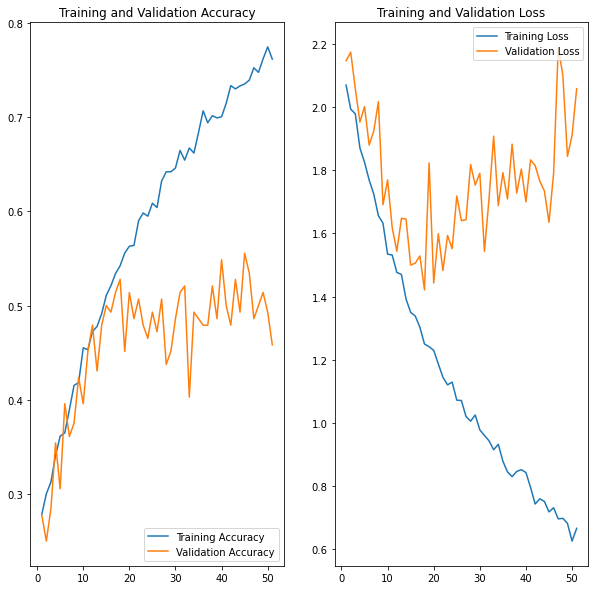

In [78]:
visualize_training(training_history1)